# Absorção de gammas por materiais

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters

from common import *

%matplotlib inline

Raios gamma (e X) tem uma probabilidade não-nula de interagir com a matéria, sofrendo espalhamento ou mesmo sendo absorvidos. Por esta razão, ao incidir radiação gama num material observamos que, a cada $N_0$ fótons incidentes, restam

$$ N(x) = N_0 e^{-(\rho x) \mu / \rho} $$

fótons após atravessar uma espessura $x$ do material. O produto $\rho x$ costuma ser denominado espessura, sendo medido em unidades de massa por comprimento ao quadrado. A razão $\mu/\rho$, por sua vez, é denominada _mass attenuation coefficient_, ou apenas coeficiente de atenuação.

Neste experimento verificamos esta relação, detectando a radiação gama de uma fonte de ${}^{137}$Cs, na região da linha de 661 keV, que atravessou pequenas chapas de alumínio e chumbo de espessura variada. Fazendo um gráfico do logaritmo da taxa de contagens vs. espessura para cada um dos materiais conseguimos recuperar a taxa de contagens antes e o coeficiente de atenuação por um ajuste linear, pois

$$ \log \frac{dN}{dt}(x) = \log \frac{dN_0}{dt} - \frac{\mu}{\rho} \left(\rho x\right). $$

Tomamos então o espectro gama, na região da linha de 661 keV, da radiação que atravessou 10 diferentes chapas de alumínio e 4 diferentes chapas de chumbo, assim como da radiação sem obstáculos. Para a análise

* Obtemos o número de _net counts_, definido como o número de contagens na linha do ${}^{137}$Cs, descontadas as contagens correspondentes a um baseline linear entre os extremos da janela de observação que define a linha.
* Obtemos o _live time_ registrado pelo programa de aquisição (tempo de aquisição descontado do tempo morto do detector)
* Obtemos a taxa de contagens (_net count rate_) dividindo _net counts_ por _live time_ para cada observação
* Estimamos o erro de _net count rate_ como a raiz da razão _net count rate_ por _live time_ (verifique a seção de estatísticas de contagem).
* Fizemos o gráfico de log(_net count rate_) por log(_espessura_) e com um ajuste linear obtivemos o coeficiente de atenuação.

In [2]:
data_dir = '../../dados/'

arquivos = [
    'cs137_absorcao_gamma_alg_29032017_1507.tsv',
    'cs137_absorcao_gamma_alh_29032017_1523.tsv',
    'cs137_absorcao_gamma_ali_29032017_1528.tsv',
    'cs137_absorcao_gamma_alj_29032017_1534.tsv',
    'cs137_absorcao_gamma_alk_29032017_1539.tsv',
    'cs137_absorcao_gamma_all_29032017_1545.tsv',
    'cs137_absorcao_gamma_alm_29032017_1550.tsv',
    'cs137_absorcao_gamma_aln_29032017_1557.tsv',
    'cs137_absorcao_gamma_alo_29032017_1603.tsv',
    'cs137_absorcao_gamma_alp_29032017_1609.tsv',
    'cs137_absorcao_gamma_pbq_29032017_1652.tsv',
    'cs137_absorcao_gamma_pbr_29032017_1644.tsv',
    'cs137_absorcao_gamma_pbs_29032017_1634.tsv',
    'cs137_absorcao_gamma_pbt_29032017_1625.tsv',
]
        
medidas = {
    arquivo[23].upper(): os.path.join(data_dir, arquivo) for arquivo in arquivos
}
medidas['0'] = os.path.join(data_dir, 'cs137_absorcao_gamma_29032017_1458.tsv')


arq_dados_amostras = os.path.join(data_dir, "gamma.csv")

df = pd.read_csv(arq_dados_amostras)
# Calcula net_count_rate (já descontadas contagens do baseline)
df['Net count rate'] = df['Código'].apply(lambda x: load_net_count_rate(medidas[x])[0])
# Calcula o tempo vivo
df['Live time'] = df['Código'].apply(lambda x: load_live_time(medidas[x]))
# Calcula o erro
df['Error'] = df['Net count rate']/df['Live time'].apply(np.sqrt)
df

,Material,Código,Espessura (in),Espessura (cm),Densidade área (mg/cm^2),Net count rate,Live time,Error
0,Al,G,0.020,0.05080,129,98.200860,255.44,6.144278
1,Al,H,0.025,0.06350,161,99.989438,273.18,6.049642
2,Al,I,0.032,0.08128,206,100.746510,253.86,6.323141
3,Al,J,0.040,0.10160,258,97.662391,252.88,6.141439
4,Al,K,0.050,0.12700,328,96.286848,272.33,5.834709
5,Al,L,0.063,0.16002,419,91.055594,264.84,5.595190
6,Al,M,0.080,0.20320,516,93.087206,290.27,5.463726
7,Al,N,0.090,0.22860,590,96.824823,341.17,5.242052
8,Al,O,0.100,0.25400,645,92.179107,289.80,5.414811
9,Al,P,0.125,0.31750,849,95.458010,284.66,5.657820


Material:  Al
a = -0.091, da = 0.032
b = 4.604, db = 0.015
Chi quadrado:  0.00187515763904
Material:  Pb
a = -0.115, da = 0.003
b = 4.593, db = 0.013
Chi quadrado:  0.000431940464513


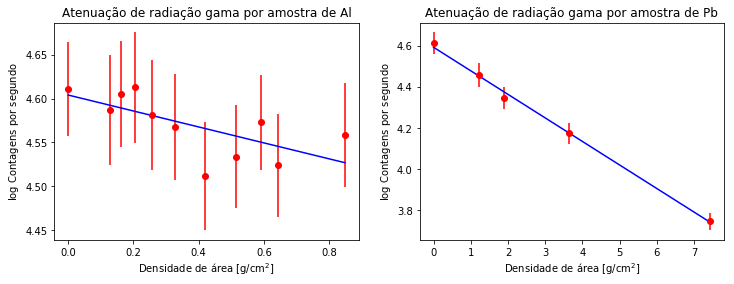

In [3]:
# Gráficos e ajustes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, material in enumerate(['Al', 'Pb']):

    thickness = np.array(df[df.Material.isin([material, '-'])]['Densidade área (mg/cm^2)']) * 0.001
    net_count_rate = np.array(df[df.Material.isin([material, '-'])]['Net count rate'])
    error = np.array(df[df.Material.isin([material, '-'])]['Error'])

    pvar, pcov = curve_fit(lambda x, a, b: a*x + b, thickness, np.log(net_count_rate), sigma=error/net_count_rate)
    a = pvar[0]
    b = pvar[1]
    da, db = np.sqrt(np.diag(pcov))
    xs = np.linspace(0, thickness.max(), 1000)
    ys = a*xs + b
    
    print("Material: ", material)
    print("a = {:.3f}, da = {:.3f}".format(a, da))
    print("b = {:.3f}, db = {:.3f}".format(b, db))
    
    ax = axs[i]
    ax.set_xlabel("Densidade de área [g/cm$^2$]")
    ax.set_ylabel(r"$\log$ Contagens por segundo")
    titulo = "Atenuação de radiação gama por amostra de " + material
    ax.set_title(titulo)
    
    degrees_freedom = len(ys) - 2
    chi_sq = 1 / degrees_freedom * np.sum(((net_count_rate - np.exp(a * thickness + b)) / error) ** 2)
    print("Chi quadrado: ", chi_sq)

    ax.errorbar(thickness, np.log(net_count_rate), yerr=error/net_count_rate, fmt='ro')
    ax.plot(xs, ys, 'b')

In [4]:
fig.savefig('absorcao_gamma.pdf')

Note que os coeficientes lineares do ajustes para o Pb e o Al são consistentes (como deveriam ser, pois correspondem à taxa de contagens na ausência de obstáculos). Para o Alumínio, o coeficiente angular do ajuste nos fornece um coeficiente de atenuação de 

$\left(\frac{\mu}{\rho}\right)_{Al} = 0.09 \pm 0.03$ cm$^2$/g

Valor consistente com o valor padrão do NIST para o coeficiente de atenuação a uma energia de $600$ keV (0.0780 cm$^2$/g).

Já para o Chumbo, o coeficiente obtido foi

$\left(\frac{\mu}{\rho}\right)_{Pb} = 0.115 \pm 0.003$ cm$^2$/g

próximo do valor padrão do NIST para o coeficiente de atenuação a uma energia de $600$ keV (0.1248 cm$^2$/g). A inconsistência pode ser devida tanto ao fato de o valor padrão ser dada numa energia diferente da utilizada quanto pois na verdade não medimos apenas a radiação que atravessou o material sem sofrer espalhamento, mas uma pequena parcela da radiação espalhada também. Com isto a taxa de contagens obtida experimentalmente é ligeiramente superestimada, o que pode fazer com que o coeficiente angular do ajuste seja subestimado.